## First benchmark

To benchmark: estimating disassembly indexes for increasing levels of complex peptidomes


        

In [17]:
from disassembly.simulate_proteolysis import enzyme_set, enzyme, amino_acids


enzymes1 = enzyme_set(
    [
        enzyme({"K": 1}, "K protease"),
    ],
    [1],
    [1],
)

enzymes2 = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "K+R protease"),
    ],
    [1],
    [1],
)


enzymes3 = enzyme_set(
    [
        enzyme({"V": 0.3, "I": 0.3, "A": 0.2, "T": 0.1}, "V+I+A+T protease"),
    ],
    [1],
    [1],
)

random = enzyme_set(
    [enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)

In [18]:
protein = "MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE"

In [19]:
from disassembly.simulate_proteolysis import simulate_proteolysis
from disassembly.estimate_weights import estimate_weights
from disassembly.disassembly import (
    get_disassembly,
    get_disassembly_indexes,
    get_disassembly_indexes_mc,
)

results = {}
test_names = ["simple", "medium", "complex", "random"]
iterations = 3
simulated_peptidomes = {}
simulated_graphs = {}
generated_graphs = {}

# Simulating peptidomes
for test_name, enzymes in zip(test_names, [enzymes1, enzymes2, enzymes3, random]):
    simulated_peptidomes[test_name] = {}
    simulated_graphs[test_name] = {}
    for iteration in range(iterations):
        print(f"Running {test_name} {iteration}")
        simulated_peptidome, simulated_graph = simulate_proteolysis(
            protein,
            enzymes,
            n_start=3,
            n_generate=250,
            endo_or_exo_probability=[0.5, 0.5],
        )
        simulated_peptidomes[test_name][iteration] = simulated_peptidome
        simulated_graphs[test_name][iteration] = simulated_graph

# Running estimation
for test_name, enzymes in zip(test_names, [enzymes1, enzymes2, enzymes3, random]):
    results[test_name] = {}
    generated_graphs[test_name] = {}
    for iteration in range(iterations):
        results[test_name][iteration] = {}
        G, kls, generated, weights = estimate_weights(
            P=simulated_peptidomes[test_name][iteration],
            meta_enzyme=enzymes.meta_enzyme,
            exo_mult_factor=2,
            lr=1,
            n_iterations=1000,
            alpha=0.05,
        )
        generated_graphs[test_name][iteration] = G
        results[test_name][iteration]["kl"] = kls
        results[test_name][iteration]["rdi"] = get_disassembly_indexes(
            simulated_graphs[test_name][iteration]
        )
        results[test_name][iteration]["rd"] = get_disassembly(
            simulated_peptidomes[test_name][iteration],
            results[test_name][iteration]["rdi"],
        )
        results[test_name][iteration]["edi"] = get_disassembly_indexes_mc(G, 10000)
        results[test_name][iteration]["ed"] = get_disassembly(
            simulated_peptidomes[test_name][iteration],
            results[test_name][iteration]["edi"],
        )

Running simple 0
 249 / 250 (292)
154 unique peptides. 253 total
Running simple 1
 249 / 250 (302)
152 unique peptides. 253 total
Running simple 2
 248 / 250 (296)
151 unique peptides. 253 total
Running medium 0
 249 / 250 (298)
175 unique peptides. 253 total
Running medium 1
 249 / 250 (297)
193 unique peptides. 253 total
Running medium 2
 249 / 250 (293)
184 unique peptides. 253 total
Running complex 0
 249 / 250 (305)
212 unique peptides. 253 total
Running complex 1
 249 / 250 (299)
211 unique peptides. 253 total
Running complex 2
 249 / 250 (297)
196 unique peptides. 253 total
Running random 0
 249 / 250 (296)
228 unique peptides. 253 total
Running random 1
 249 / 250 (305)
231 unique peptides. 253 total
Running random 2
 249 / 250 (301)
235 unique peptides. 253 total
 14 / 1000 | 0.20, mean: 0.52 | Decreasing | nz: 1159

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


 100 / 1000 | 0.05, mean: 0.23 | Increasing | nz: 1146
Learning rate decreased to 0.5
 153 / 154 | checking 1 pathss | Decreasing | nz: 1432
 Averaged DI: 2.76

 Averaged DI: 3.60
 151 / 152 | checking 1 paths | Plateau | nz: 9570008
 Averaged DI: 2.52

 Averaged DI: 3.38
 150 / 151 | checking 1 pathss| Plateau | nz: 1010084
 Averaged DI: 2.89

 Averaged DI: 3.59
 174 / 175 | checking 1 paths | Plateau | nz: 9564412
 Averaged DI: 2.38

 Averaged DI: 2.78
 192 / 193 | checking 1 paths | Plateau | nz: 9919760
 Averaged DI: 2.13

 Averaged DI: 2.60
 183 / 184 | checking 1 pathss| Plateau | nz: 1018090
 Averaged DI: 2.56

 Averaged DI: 2.96
 211 / 212 | checking 1 paths | Plateau | nz: 9872316
 Averaged DI: 2.13

 Averaged DI: 2.65
 99 / 1000 | 0.00, mean: 0.00 | Plateau | nz: 1128120
Learning rate decreased to 0.5
 210 / 211 | checking 1 paths
 Averaged DI: 2.17

 Averaged DI: 2.75
 195 / 196 | checking 1 paths | Plateau | nz: 1358361
 Averaged DI: 2.46

 Averaged DI: 2.96
 227 / 228 | ch

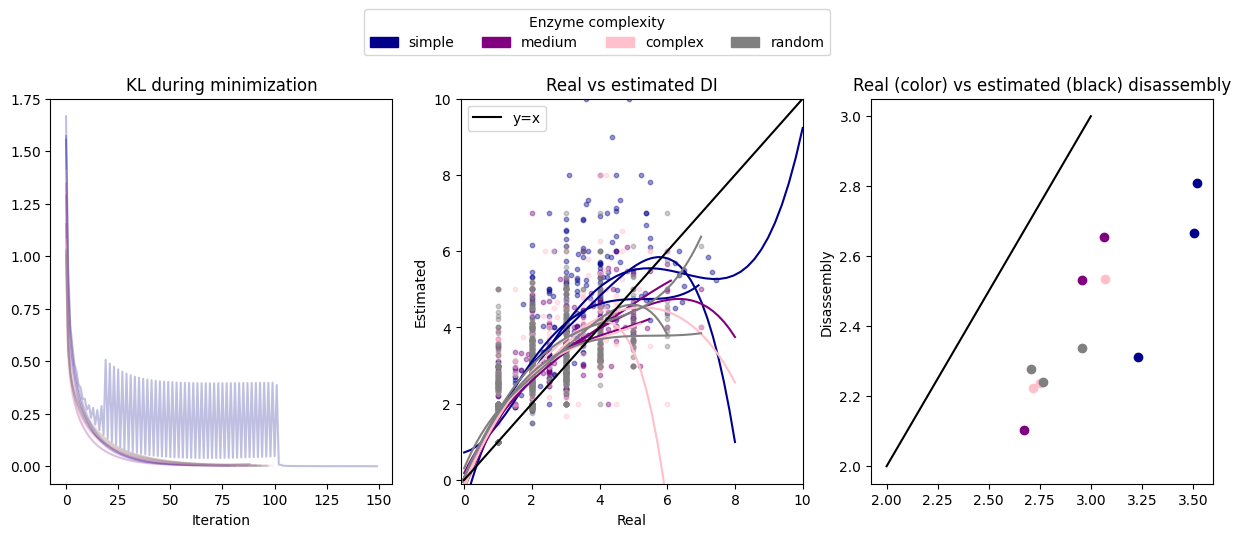

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from disassembly.util import get_nrmse

# Plotting KL-div
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
colors = ["darkblue", "purple", "pink", "gray"]

for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        axs[0].plot(
            results[test_name][iteration]["kl"],
            label=test_name,
            c=colors[i],
            alpha=0.25,
        )

# plotting corr DI
nrmse = {}
for i, test_name in enumerate(test_names):
    nrmse[test_name] = {}
    for iteration in range(iterations):
        real_di = results[test_name][iteration]["rdi"]
        estimated_di = results[test_name][iteration]["edi"]

        r_di = []
        e_di = []
        for sequence in real_di.keys():
            r_di.append(real_di[sequence])
            e_di.append(estimated_di[sequence])

        regress = np.polyfit(r_di, e_di, 4)

        axs[1].plot(
            np.linspace(0, max(e_di)),
            regress[0] * np.linspace(0, max(e_di)) ** 4
            + regress[1] * np.linspace(0, max(e_di)) ** 3
            + regress[2] * np.linspace(0, max(e_di)) ** 2
            + regress[3] * np.linspace(0, max(e_di))
            + regress[4],
            color=colors[i],
        )
        axs[1].scatter(r_di, e_di, c=colors[i], alpha=0.4, s=10)
        nrmse[test_name][iteration] = get_nrmse(r_di, e_di)

axs[1].plot(np.linspace(0, 12, 100), np.linspace(0, 12, 100), "black", label="y=x")
axs[1].legend()

# plotting real vs estimated disassembly
for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        real_d = results[test_name][iteration]["rd"]
        estimated_d = results[test_name][iteration]["ed"]

        axs[2].scatter(real_d, estimated_d, color=colors[i])
axs[2].plot(np.linspace(2, 3, 100), np.linspace(2, 3, 100), "black", label="y=x")
axs[2].legend()


axs[0].set_title("KL during minimization")
axs[0].set_xlabel("Iteration")
axs[1].set_title("Real vs estimated DI")
axs[1].set_xlabel("Real")
axs[1].set_ylabel("Estimated")
axs[2].set_title("Disassembly")
axs[2].set_xlabel("Real")
axs[2].set_ylabel("Estimated")
axs[1].set_xlim([-.1, 10])
axs[1].set_ylim([-.1, 10])

import matplotlib.patches as mpatches

patches = []
for test_name, color in zip(test_names, colors):
    patches.append(mpatches.Patch(color=color, label=test_name))

plt.legend(
    handles=patches,
    bbox_to_anchor=(-0.1, 1.25),
    ncol=4,
    title="Enzyme complexity",
)

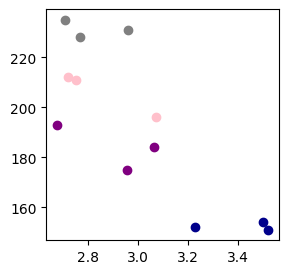

In [21]:
fig = plt.figure(figsize=(3, 3))
for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        edi = results[test_name][iteration]["ed"]
        n_pep = len(simulated_peptidomes[test_name][iteration].keys())
        plt.scatter(edi, n_pep, c=colors[test_names.index(test_name)])

# Gradient descent

In [22]:
from disassembly.estimate_weights_gd import estimate_weights

for test_name, enzymes in zip(test_names, [enzymes1, enzymes2, enzymes3, random]):
    results[test_name] = {}
    generated_graphs[test_name] = {}
    for iteration in range(iterations):
        print(test_name, iteration)
        results[test_name][iteration] = {}
        G, kls, generated, weights = estimate_weights(
            true_dict=simulated_peptidomes[test_name][iteration],
            lr=0.0005,
            n_iterations=500,
        )
        generated_graphs[test_name][iteration] = G
        results[test_name][iteration]["kl"] = kls
        results[test_name][iteration]["rdi"] = get_disassembly_indexes(
            simulated_graphs[test_name][iteration]
        )
        results[test_name][iteration]["rd"] = get_disassembly(
            simulated_peptidomes[test_name][iteration],
            results[test_name][iteration]["rdi"],
        )
        results[test_name][iteration]["edi"] = get_disassembly_indexes_mc(G, 10000)

        results[test_name][iteration]["ed"] = get_disassembly(
            simulated_peptidomes[test_name][iteration],
            results[test_name][iteration]["edi"],
        )

simple 0
 99 / 500 | 0.73, mean: 0.88 | Stochastic | nz: 16198
Learning rate decreased to 0.00025
 153 / 154 | checking 1 pathss| Plateau | nz: 1574588
 Averaged DI: 2.76

 Averaged DI: 2.71
simple 1
 109 / 500 | 1.02, mean: 0.84 | Increasing | nz: 1252
Learning rate decreased to 0.00025
 151 / 152 | checking 1 paths | Plateau | nz: 1304307
 Averaged DI: 2.52

 Averaged DI: 2.70
simple 2
 115 / 500 | 1.36, mean: 1.20 | Increasing | nz: 12520
Learning rate decreased to 0.00025
 150 / 151 | checking 1 pathss| Plateau | nz: 1337349
 Averaged DI: 2.89

 Averaged DI: 2.79
medium 0
 124 / 500 | 0.81, mean: 0.83 | Increasing | nz: 1139
Learning rate decreased to 0.00025
 174 / 175 | checking 1 paths | Plateau | nz: 1129180
 Averaged DI: 2.38

 Averaged DI: 2.44
medium 1
 104 / 500 | 0.87, mean: 0.90 | Increasing | nz: 1265
Learning rate decreased to 0.00025
 168 / 500 | 0.88, mean: 0.85 | Increasing | nz: 1258
Learning rate decreased to 0.000125
 192 / 193 | checking 1 paths | Plateau | nz: 1

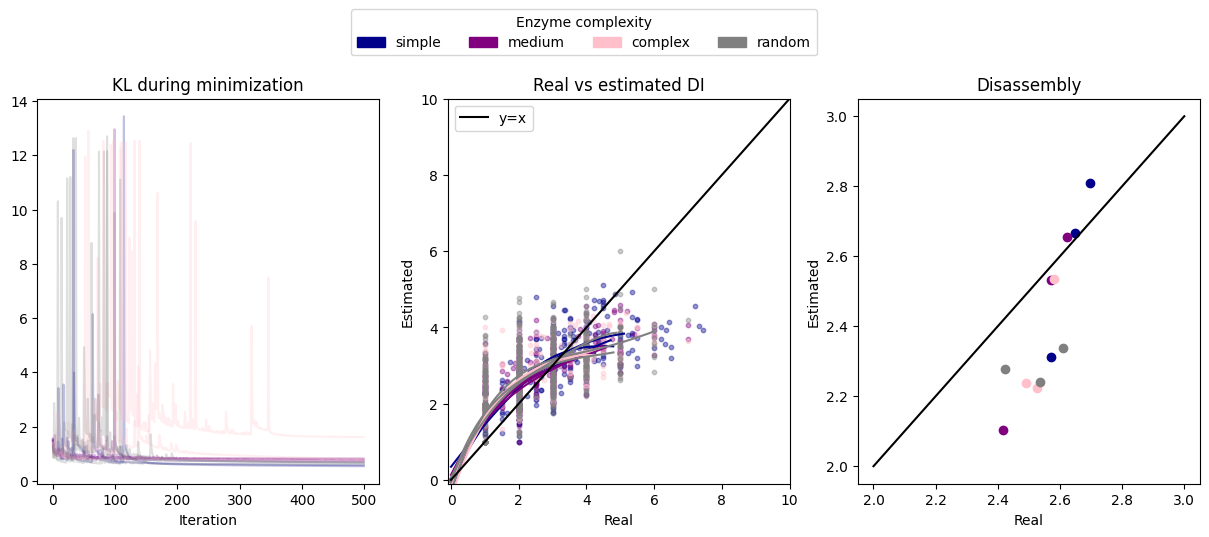

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from disassembly.util import get_nrmse

# Plotting KL-div
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
colors = ["darkblue", "purple", "pink", "gray"]

for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        axs[0].plot(
            results[test_name][iteration]["kl"],
            label=test_name,
            c=colors[i],
            alpha=0.25,
        )

# plotting corr DI
nrmse = {}
for i, test_name in enumerate(test_names):
    nrmse[test_name] = {}
    for iteration in range(iterations):
        real_di = results[test_name][iteration]["rdi"]
        estimated_di = results[test_name][iteration]["edi"]

        r_di = []
        e_di = []
        for sequence in real_di.keys():
            r_di.append(real_di[sequence])
            e_di.append(estimated_di[sequence])

        regress = np.polyfit(r_di, e_di, 4)

        axs[1].plot(
            np.linspace(0, max(e_di)),
            regress[0] * np.linspace(0, max(e_di)) ** 4
            + regress[1] * np.linspace(0, max(e_di)) ** 3
            + regress[2] * np.linspace(0, max(e_di)) ** 2
            + regress[3] * np.linspace(0, max(e_di))
            + regress[4],
            color=colors[i],
        )
        axs[1].scatter(r_di, e_di, c=colors[i], alpha=0.4, s=10)
        nrmse[test_name][iteration] = get_nrmse(r_di, e_di)

axs[1].plot(np.linspace(0, 12, 100), np.linspace(0, 12, 100), "black", label="y=x")
axs[1].legend()

# plotting real vs estimated disassembly
for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        real_d = results[test_name][iteration]["rd"]
        estimated_d = results[test_name][iteration]["ed"]

        axs[2].scatter(estimated_d, real_d, color=colors[i])
axs[2].plot(np.linspace(2, 3, 100), np.linspace(2, 3, 100), "black", label="y=x")
axs[2].legend()


axs[0].set_title("KL during minimization")
axs[0].set_xlabel("Iteration")
axs[1].set_title("Real vs estimated DI")
axs[1].set_xlabel("Real")
axs[1].set_ylabel("Estimated")
axs[2].set_title("Real (color) vs estimated (black) disassembly")
axs[2].set_title("Disassembly")
axs[2].set_xlabel("Real")
axs[2].set_ylabel("Estimated")
axs[1].set_xlim([-.1, 10])
axs[1].set_ylim([-.1, 10])

import matplotlib.patches as mpatches

patches = []
for test_name, color in zip(test_names, colors):
    patches.append(mpatches.Patch(color=color, label=test_name))

plt.legend(
    handles=patches,
    bbox_to_anchor=(-0.1, 1.25),
    ncol=4,
    title="Enzyme complexity",
)

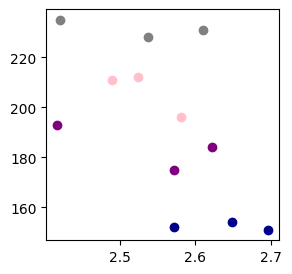

In [24]:
fig = plt.figure(figsize=(3, 3))
for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        edi = results[test_name][iteration]["ed"]
        n_pep = len(simulated_peptidomes[test_name][iteration].keys())
        plt.scatter(edi, n_pep, c=colors[test_names.index(test_name)])

# Peptidomes

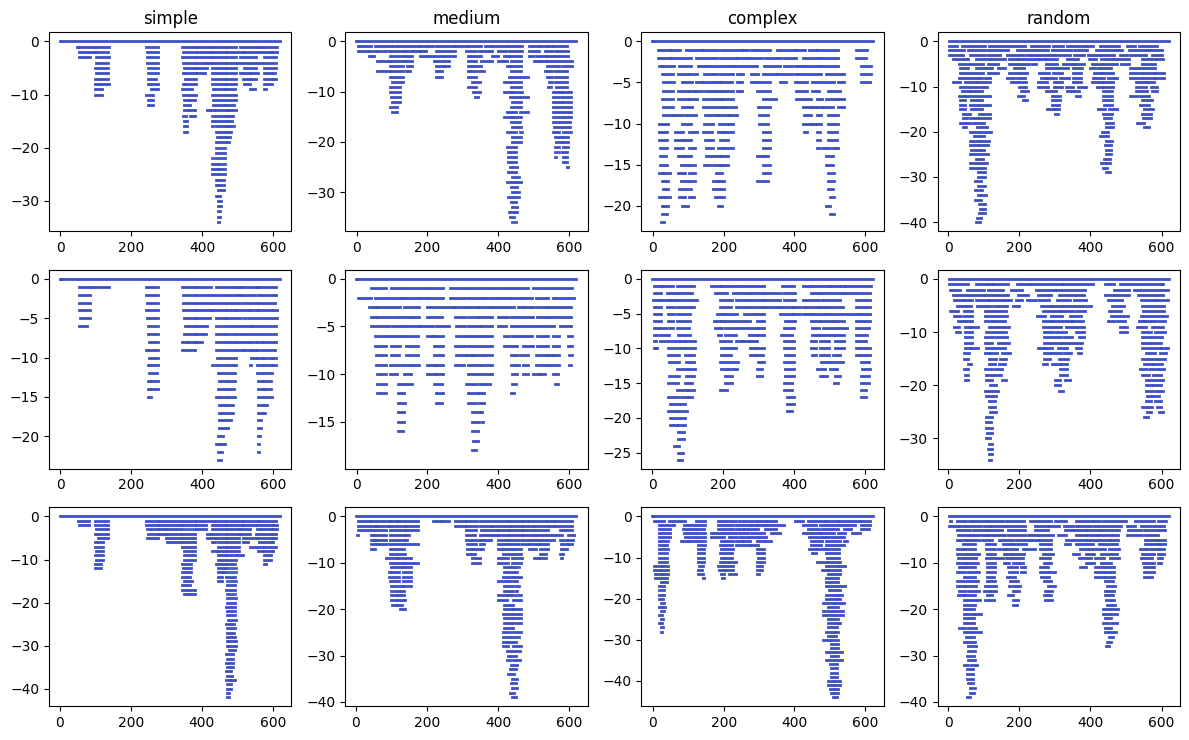

In [25]:
from disassembly.util import plot_peptidome

fig, axs = plt.subplots(
    iterations, len(test_names), figsize=(len(test_names) * 3, iterations * 2.5)
)
for iteration in range(iterations):
    for test_name in test_names:
        ax = axs[iteration, test_names.index(test_name)]
        if iteration == 0:
            ax.set_title(test_name)
        plot_peptidome(protein, simulated_peptidomes[test_name][iteration], ax)
plt.tight_layout()